In [1]:
import numpy as np
from tqdm.auto import tqdm
from ctapipe.instrument import CameraGeometry
from ctapipe.image.toymodel import Gaussian
from ctapipe.image import hillas_parameters
from ctapipe.visualization import CameraDisplay
from ctapipe.image.cleaning import tailcuts_clean
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
rng = np.random.default_rng(0)

In [3]:
cam = CameraGeometry.from_name("LSTCam")

true_width = 0.1 * u.m
true_length = 0.3 * u.m
true_psi = 45 * u.deg
true_x = 0.5 * u.m
true_y = -0.2 * u.m

model = Gaussian(true_x, true_y, true_length, true_width, true_psi)

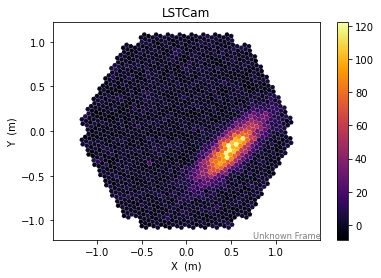

In [4]:
image, signal, background = model.generate_image(cam, intensity=10000, nsb_level_pe=10, rng=rng)

d = CameraDisplay(cam, image=image, cmap='inferno')
d.add_colorbar()

In [5]:
def sample_no_noise_no_cleaning():
    _, signal, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=0, rng=rng)
    h = hillas_parameters(cam, signal)
    return h


def sample_no_noise_with_cleaning():
    _, signal, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=0, rng=rng)
    
    mask = tailcuts_clean(cam, signal, 7, 5, min_number_picture_neighbors=2)
    
    h = hillas_parameters(cam[mask], signal[mask])
    return h


def sample_noise_with_cleaning():
    image, _, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=5, rng=rng)
    
    mask = tailcuts_clean(cam, image, 7, 5, min_number_picture_neighbors=2)
    
    h = hillas_parameters(cam[mask], image[mask])
    return h

In [6]:
trials_no_noise_no_cleaning = [sample_no_noise_no_cleaning() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
trials_no_noise_with_cleaning = [sample_no_noise_with_cleaning() for _ in tqdm(range(10000))]
trials_noise_cleaning = [sample_noise_with_cleaning() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

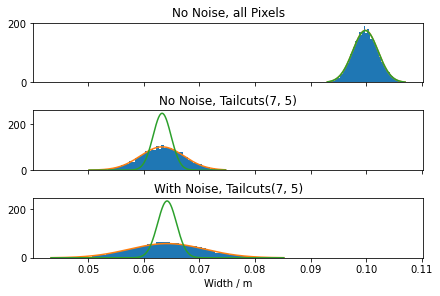

In [9]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, sharex=True)

titles = ['No Noise, all Pixels', 'No Noise, Tailcuts(7, 5)', 'With Noise, Tailcuts(7, 5)']
values = [trials_no_noise_no_cleaning, trials_no_noise_with_cleaning, trials_noise_cleaning]
for ax, trials, title in zip(axs, values, titles): 
    


    length = np.array([t.width.to_value(u.m) for t in trials])
    length_unc = np.array([t.width_uncertainty.to_value(u.m) for t in trials])
    
    limits = np.quantile(length, [0.001, 0.999])
    hist, edges, plot = ax.hist(length, bins=51, range=limits, density=True)
    
    x = np.linspace(edges[0], edges[-1], 500)

    ax.plot(x, norm.pdf(x, length.mean(), length.std()))
    ax.plot(x, norm.pdf(x, length.mean(), length_unc.mean()))
    ax.set_title(title)
axs[2].set_xlabel('Width / m')

fig.savefig("hillas_uncertainties.png", dpi=300)